In [2]:
import os
import pandas as pd
import datetime

In [3]:
csv_list = []
appended_df = pd.DataFrame()
LUIGI_LOG_PATH = '../data'
for filename in os.listdir(LUIGI_LOG_PATH):
    if filename.endswith('.csv') and filename.startswith('d'):
        log_path = LUIGI_LOG_PATH+'/'+filename
        csv_list.append(filename)
        print('Preprocessing... ',log_path)
        df = pd.read_csv(log_path, index_col=False)
        appended_df = appended_df.append(df)

#appended_df
csv_list.sort()
print(csv_list)
print(len(appended_df))
appended_df.head()

Preprocessing...  ../data/daily.2019-July_September.csv
['daily.2019-July_September.csv']
61914


,Unnamed: 0,case,activity,start_time,end_time
0,0,daily.2019-09-24_05-05-02,AllTasks,2019-09-24 05:05:32,2019-09-24 16:55:33
1,1,daily.2019-09-24_05-05-02,DumpTask(sql_filename=regular_urls)(kvs=None)(...,2019-09-24 05:20:10,2019-09-24 05:40:21
2,2,daily.2019-09-24_05-05-02,DumpTask(sql_filename=reprocess_urls)(kvs=None...,2019-09-24 05:20:10,2019-09-24 05:21:03
3,3,daily.2019-09-24_05-05-02,DumpTask(sql_filename=daily_urls)(kvs=None)(ch...,2019-09-24 05:20:10,2019-09-24 05:21:32
4,4,daily.2019-09-24_05-05-02,ProxySetupTask,2019-09-24 05:20:10,2019-09-24 05:32:45


In [5]:
def get_duration(start_time, end_time):
    start = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
    end = datetime.datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')
    duration = abs(end - start)
    return duration
#get_duration(ex['timestamp'][10],ex['timestamp'][1])

In [6]:
w_duration = appended_df.copy()
w_duration = w_duration[['case', 'activity','start_time','end_time']]
w_duration['duration'] = w_duration.apply(lambda row: str(get_duration(row['start_time'],row['end_time'])), axis=1)
w_duration['t_duration']= w_duration.apply(lambda row: (get_duration(row['start_time'],row['end_time']).total_seconds())/60/60, axis=1)


w_duration = w_duration[['case','activity','start_time','end_time', 'duration', 't_duration']]
print(len(w_duration))
w_duration.head()

19455


,case,activity,start_time,end_time,duration,t_duration
0,daily.2019-09-04_23-23-01.csv,AllTasks,2019-09-04 23:23:20,2019-09-06 20:33:05,"1 day, 21:09:45",45.162500
1,daily.2019-09-04_23-23-01.csv,DumpTask,2019-09-04 23:35:08,2019-09-04 23:36:33,0:01:25,0.023611
2,daily.2019-09-04_23-23-01.csv,DumpTask,2019-09-04 23:35:08,2019-09-05 00:00:34,0:25:26,0.423889
3,daily.2019-09-04_23-23-01.csv,DumpTask,2019-09-04 23:35:08,2019-09-04 23:35:58,0:00:50,0.013889
4,daily.2019-09-04_23-23-01.csv,ProxySetupTask,2019-09-04 23:35:08,2019-09-04 23:51:32,0:16:24,0.273333


In [7]:
dur_df = w_duration
excluding = ['AllTasks']
#including = ['UpdateMongoRed']
#including = ['GroupCategoryAggregateGroups','TransformMap']
#including = ['GroupCategoryAggregateGroups','TransformMap','MapCategoryReduceBuild','ClusterCategoryEnrichMatchesWithSourceId','MongoDump', 'IncJoinTask']
#including = ['AllTasks','RestartTask', 'GroupPerformanceTask', 'ReviewTsTask', 'DumpTask', 'SourceCategoryTask', 'GroupTsTask', 'IndexFileTask', 'GroupMgmtScoreDistTask', 'MgmtScoreDistTask']

print(len(dur_df))

#top_long_tasks = dur_df[dur_df['activity'].isin(including)]
top_long_tasks = dur_df[~dur_df['activity'].isin(excluding)]
top_long_tasks = top_long_tasks.sort_values(by=['t_duration','activity'], ascending=False)
top_long_tasks = top_long_tasks.head(5000)

#top_long_tasks = top_long_tasks[top_long_tasks['activity']!='CrawlTask']

top_long_task_calls = dur_df[dur_df['activity']!='AllTasks']
top_long_task_calls = top_long_task_calls.sort_values(by=['t_duration'], ascending=False)
top_long_task_calls = top_long_task_calls.head(10)

#top_long_tasks.head()

19455


In [6]:
max_duration = top_long_tasks.groupby(['activity'], sort=False)['t_duration'].max().reset_index()
#.reset_index(name='max_duration').sort_values(by=['max_duration'], ascending=False)
counts = top_long_tasks.groupby(['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
act_group = pd.merge(counts, max_duration, on=['activity'], how='outer')
act_group = act_group.sort_values(by=['counts'], ascending = False)
print(len(act_group))
act_group.head()

22


,activity,counts,t_duration
0,MongoDump,4174,1.083611
1,MongoIndexConstructionTask,160,0.002500
2,UpdateMongoRed,64,11.658333
3,TransformMap,64,6.550556
4,CreateMongoIndex,64,0.005556


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

5000
            activity  t_duration
6723  UpdateMongoRed   11.658333
Saving plot in  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/table-precomp/logs/october//catts_group_boxplot_CrawlTask.png


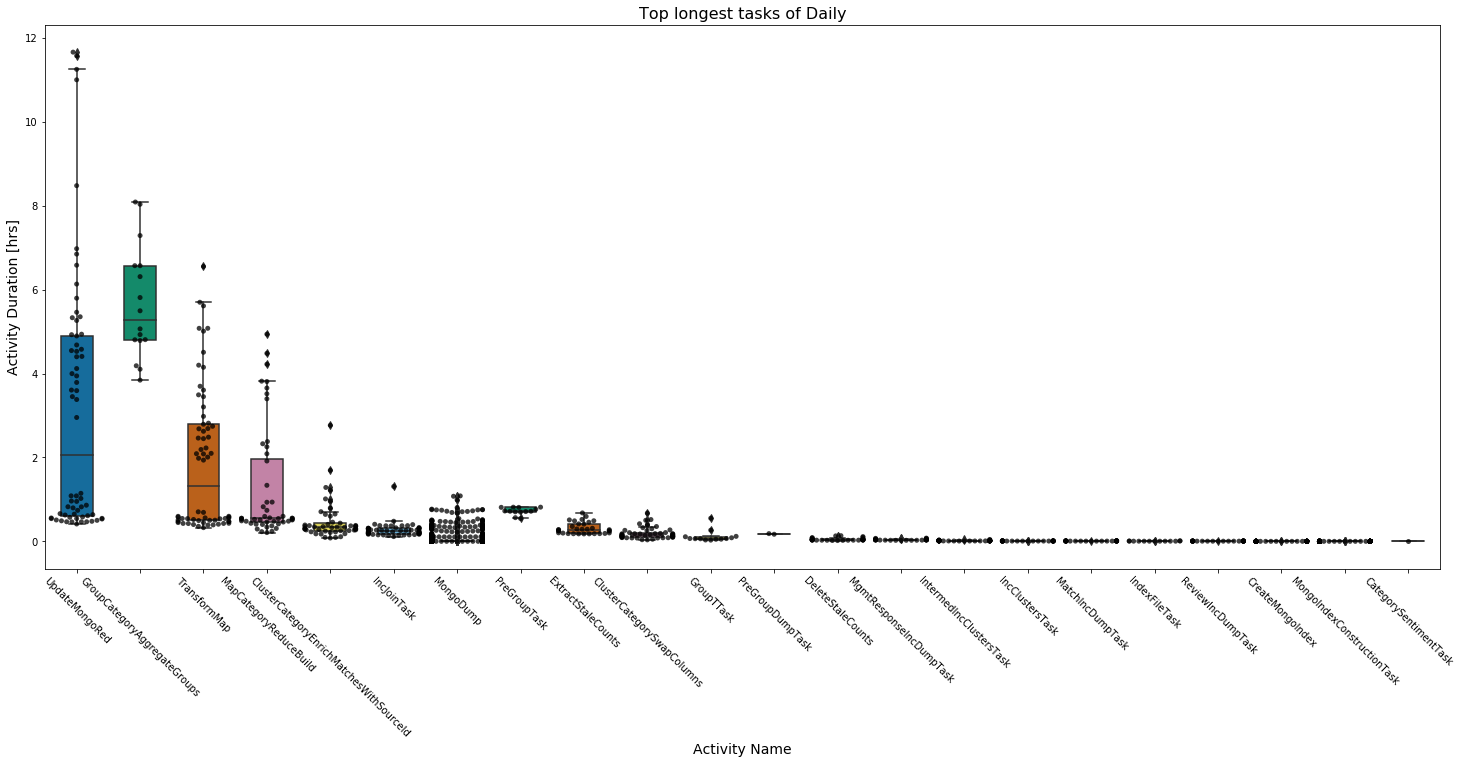

In [8]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=-45)
task_duration= top_long_tasks[['activity','t_duration']]
print(len(task_duration))
print(task_duration.head(1))
task_duration.shape

# plot boxplot with seaborn
bplot=sns.boxplot(y='t_duration', x='activity', 
                 data=task_duration, 
                 width=0.5,
                 palette="colorblind")
 
# add swarmplot
bplot=sns.swarmplot(y='t_duration', x='activity',
              data=task_duration, 
              color='black',
              alpha=0.75)

bplot.axes.set_title("Top longest tasks of Daily",
                    fontsize=16)
 
bplot.set_xlabel("Activity Name", 
                fontsize=14)
 
bplot.set_ylabel("Activity Duration [hrs]",
                fontsize=14)
 
bplot.tick_params(labelsize=10)
OUTPUT_PATH = log_path.split('.')[0]+'_boxplot_CrawlTask.png'
print('Saving plot in ',OUTPUT_PATH)
plt.savefig(OUTPUT_PATH)

5000
            activity  t_duration
6723  UpdateMongoRed   11.658333
Saving plot in  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/table-precomp/logs/october//catts_group_boxplot_CrawlTask.png


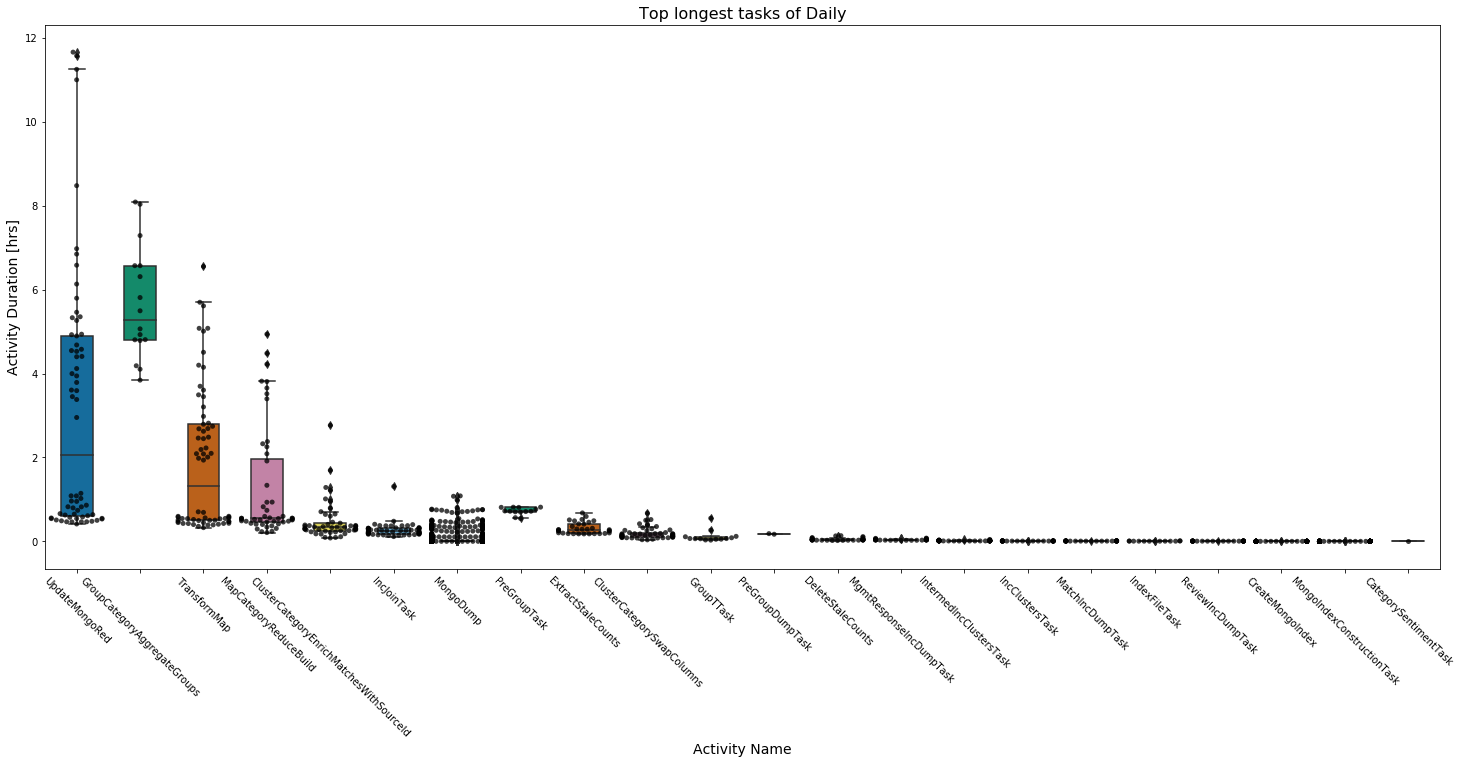

In [9]:
plt.figure(figsize=(25,10))
plt.xticks(rotation=-45)
task_duration= top_long_tasks[['activity','t_duration']]
print(len(task_duration))
print(task_duration.head(1))
task_duration.shape

# plot boxplot with seaborn
bplot=sns.boxplot(y='t_duration', x='activity', 
                 data=task_duration, 
                 width=0.5,
                 palette="colorblind")
 
# add swarmplot
bplot=sns.swarmplot(y='t_duration', x='activity',
              data=task_duration, 
              color='black',
              alpha=0.75)

bplot.axes.set_title("Top longest tasks of Daily",
                    fontsize=16)
 
bplot.set_xlabel("Activity Name", 
                fontsize=14)
 
bplot.set_ylabel("Activity Duration [hrs]",
                fontsize=14)
 
bplot.tick_params(labelsize=10)
OUTPUT_PATH = log_path.split('.')[0]+'_boxplot_CrawlTask.png'
print('Saving plot in ',OUTPUT_PATH)
plt.savefig(OUTPUT_PATH)